In [6]:
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from typing import TypedDict,Annotated
from dotenv import load_dotenv
import os
from pydantic import BaseModel, Field
import operator
from typing import Literal
from langgraph.graph.message import add_messages
from langchain_core.messages import SystemMessage, HumanMessage , BaseMessage
from langgraph.checkpoint.memory import MemorySaver , InMemorySaver

In [7]:
Api_key = os.getenv("OPENAI_API_KEY")
model = ChatOpenAI(
    model="openai/gpt-4o-mini",
    base_url="https://openrouter.ai/api/v1",
    api_key= Api_key
)

In [8]:
class structured_output(BaseModel):
    symptoms : list[str] = Field(description="Symptoms of the disease..")
    precautions : list[str] = Field(description="Precautions to take the minimize the Effect or spreadness")

In [9]:
Diagonose_model = model.with_structured_output(structured_output)

In [10]:
medicine = f"oral antifungals like terbinafine , itraconazole, and sometimes fluconazole"
Disease = f"Nail fungus.."
History = f"""
           1. He is an farmer works in wet muddy place 
            2. mud always goes into his nail 
            3. Doctors has chexcked it and also gave some medicines {medicine}
            4. Irritation and sharp paining"""
prompt = f"""Do a prper research on this  disease {Disease} and history {History} and medication {medicine} and provide some more symptoms and preacutuons to take 
           that will help the patient to take care of his disease to save it fdrom getting more worsen """

response = Diagonose_model.invoke(prompt)
response

structured_output(symptoms=['Discoloration of the nail (yellow, brown, or white)', 'Thickening of the nail', 'Brittleness or crumbling of the nail', 'Lifting of the nail from the nail bed (onycholysis)', 'A foul odor coming from the affected nails', 'Pain or discomfort around the nail', 'Itching or irritation under the nail'], precautions=['Keep feet dry and clean, especially after working in wet environments', 'Wear moisture-wicking socks and breathable shoes', 'Avoid walking barefoot in public places, such as swimming pools and locker rooms', 'Use antifungal foot powder to keep feet dry', 'Regularly trim nails and file down thickened areas to prevent further infection', 'Avoid sharing nail clippers or other personal items to prevent spreading the infection', 'Consider using a barrier cream on hands to protect nails while working in muddy conditions', 'Consult with a healthcare professional for regular check-ups and monitor the effectiveness of treatment.'])

In [11]:
class Diagonose(TypedDict):
    Disease : str 
    Validity : Literal["Valid","Invalid"]
    History : str
    Medicine : str
    response : str

In [12]:
def check_validity(state : Diagonose)-> dict:
    Disease = state['Disease']
    prompt = f"Check Weather this disease is a valid skin disease {Disease} \n\n response with only 'Valid' or 'Invalid' , Nothing else "
    response = model.invoke(prompt).content
    if response == "Valid":
        return {
            "Validity" : "Valid"
        }
    return {
        "Validity" : "Invalid"
       }

In [13]:
def validity_router(state: Diagonose):
    if state['Validity'] == "Valid":
        return "Diagonse_the_disease"
    else:
        return "Take_valid_input"

In [14]:
def Diagonse_the_disease(state : Diagonose):
    message = [
        SystemMessage(content=f"You are an expert dermatologist with 25 years of experience.."),
        HumanMessage(content=f"""Do a prper research on this  disease {state["Disease"]} and history {state["History"]} and medication {state["Medicine"]} and provide some more symptoms and preacutuons to take 
           that will help the patient to take care of his disease to save it fdrom getting more worsen
                     ..\n \n Give a step by step plan to take action accoedingy """)
    ]
    response = Diagonose_model.invoke(message)
    return {
        "response" : response
    }
    

In [15]:
def Take_valid_input(state: Diagonose):
    print("The disease name is wrong .. please enter correct disease name")
    Disease = input("Enter disease name")
    return {
        "Disease" : Disease
    }

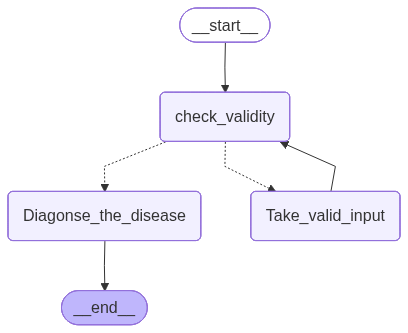

In [ ]:
check_pointer = InMemorySaver()
graph = StateGraph(Diagonose)

graph.add_node("check_validity", check_validity)
graph.add_node("Diagonse_the_disease", Diagonse_the_disease)
graph.add_node("Take_valid_input", Take_valid_input)

graph.set_entry_point("check_validity")

graph.add_conditional_edges(
    "check_validity",
    validity_router,
    {
        "Diagonse_the_disease": "Diagonse_the_disease",
        "Take_valid_input": "Take_valid_input"
    }
)

graph.add_edge("Take_valid_input", "check_validity")
graph.add_edge("Diagonse_the_disease", END)

workflow = graph.compile(checkpointer=check_pointer)

workflow

In [ ]:
medicine = f"oral antifungals like terbinafine , itraconazole, and sometimes fluconazole"
Disease = f"hgdyag"
History = f"""
           1. He is an farmer works in wet muddy place 
            2. mud always goes into his nail 
            3. Doctors has chexcked it and also gave some medicines {medicine}
            4. Irritation and sharp paining"""

In [25]:
thread_id = "123"
while True: 
    user_inp = input("Enter the disease Name : ")
    print(f"User : {Disease}")
    if user_inp.strip().lower() in ["quit" , "exit"]:
        break
    History = input("Tell your medical history if any ")
    medicine = input("tell me the medicine you are taking currently ..")
    Disease = input("Type here :")
    config = {
        "configureable":{
            "thread_id" : thread_id
        }
    }
    initial_state = {
    "Disease" : Disease,
    "History" : History,
    "Medicine" : medicine
    }      
    response = workflow.invoke(initial_state,config=config)
    print(f"AI:  {response}")
    while True:
        inp = input("More to know ?>")
        if inp.strip().lower() in ["quit" , "exit"]:
            break
        print("Humen :",inp)
        prompt =f""" The patient has this disease {Disease} and medical history {History} and taking medicine {medicine} and the doctor has given 
                 to take this precaution and care {response['response']}, now user has the quary {inp} based on everything 
                                                   tell the user to do whatever required"""
        res = model.invoke(prompt)
        print(f"AI : {res.content}")



User : nail fungus
AI:  {'Disease': 'nail fungus', 'Validity': 'Valid', 'History': ' 1. He is an farmer works in wet muddy place              2. mud always goes into his nail              3. Doctors has chexcked it and also gave some medicines {medicine}             4. Irritation and sharp paining', 'Medicine': 'oral antifungals like terbinafine , itraconazole, and sometimes fluconazole', 'response': structured_output(symptoms=['Thickening of the nails', 'Discoloration of the nails (white, yellow, or brown)', 'Brittle or crumbly nails', 'Separation of the nail from the nail bed', 'Itching or irritation around the nails', 'Sharp pain in the affected nail area', 'Foul odor emanating from the affected nails'], precautions=['Keep nails trimmed and clean to prevent further infection.', 'Avoid walking barefoot in muddy or wet areas.', 'Wear breathable, moisture-wicking socks and shoes.', 'Change socks regularly, especially after working in wet conditions.', 'Disinfect toenail clippers and na

In [19]:
initial_state = {
    "Disease" : Disease,
    "History" : History,
    "Medicine" : medicine
}
final_state = workflow.invoke(initial_state)
final_state["response"]

The disease name is wrong .. please enter correct disease name


structured_output(symptoms=['Thickened nails', 'Discoloration of nails (yellow, brown, or white)', 'Brittle or crumbly nails', 'Distorted nail shape', 'Separation of the nail from the nail bed', 'Pain or discomfort around the nail area', 'Foul odor from the affected nail'], precautions=['Keep feet dry and clean, especially after working in wet conditions', 'Wear waterproof footwear or mud boots when working in muddy areas', 'Change socks daily and use moisture-wicking materials', 'Avoid walking barefoot in public showers or pools to prevent fungal infections', 'Regularly trim nails and keep them short to prevent further irritation', 'Use antifungal powder in shoes to reduce moisture', 'Seek regular follow-up with a dermatologist for monitoring and management of the condition'])